# Advanced Lane Lines

Todolist:
- Check max curvature (US gov rules)
- Replace the curve function?
- Create class
- Tips: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/7ee45090-7366-424b-885b-e5d38210958f

## Calibration

In [185]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

np.set_printoptions(threshold=1500)

import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

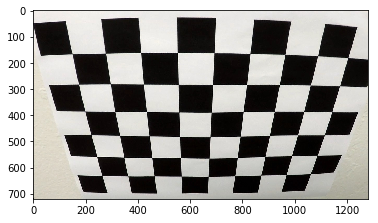

In [2]:
%matplotlib inline
img = mpimg.imread("camera_cal/calibration2.jpg")

plt.imshow(img)

In [3]:
objpoints = [] # 3D points in real world
imgpoints = [] # 2D points in 2D image represenataion of real world

# Generate all grid points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

objp

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 3.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 5.,  0.,  0.],
       [ 6.,  0.,  0.],
       [ 7.,  0.,  0.],
       [ 8.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  1.,  0.],
       [ 3.,  1.,  0.],
       [ 4.,  1.,  0.],
       [ 5.,  1.,  0.],
       [ 6.,  1.,  0.],
       [ 7.,  1.,  0.],
       [ 8.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 3.,  2.,  0.],
       [ 4.,  2.,  0.],
       [ 5.,  2.,  0.],
       [ 6.,  2.,  0.],
       [ 7.,  2.,  0.],
       [ 8.,  2.,  0.],
       [ 0.,  3.,  0.],
       [ 1.,  3.,  0.],
       [ 2.,  3.,  0.],
       [ 3.,  3.,  0.],
       [ 4.,  3.,  0.],
       [ 5.,  3.,  0.],
       [ 6.,  3.,  0.],
       [ 7.,  3.,  0.],
       [ 8.,  3.,  0.],
       [ 0.,  4.,  0.],
       [ 1.,  4.,  0.],
       [ 2.,  4.,  0.],
       [ 3.,  4.,  0.],
       [ 4.,  4.,  0.],
       [ 5.,  4.

In [4]:
# Import all calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Loop through all calibration images
for cal_fname in cal_images:
    # Read each image
    cal_img = cv2.imread(cal_fname)

    # Convert to grayscale
    gray = cv2.cvtColor(cal_img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners found, add points to arrays
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw the corners
        img_corners = cv2.drawChessboardCorners(cal_img, (9,6), corners, ret)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Undistortion

In [5]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

## Perspective transform

In [6]:
src = np.float32([
    [580, 460], # LT
    [703, 460], # RT
    [205, 720], # LB
    [1110, 720], # RB
])

dst = np.float32([
    [320, 0], # LT
    [960, 0], # RT
    [320, 720], # LB
    [960, 720], # RB
])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Get image coordinates as source for perspective change
def change_perspective(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

## Select the lines
Using:
- Gradient Threshold
- Color spaces

### Threshold

In [56]:
# Inspired by lessons of this project
def gradient_sobel_threshold(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def combine_thresholds(gradx_bin, grady_bin, mag_bin, dir_bin):
    combined = np.zeros_like(dir_bin)
    combined[((gradx_bin == 1) & (grady_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1))] = 1
    return combined

### Color

In [39]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output



### Combining gradient and color

In [57]:
def combine_binary(sxbinary, s_binary):
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

## Find lines

In [322]:
def find_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ###### 
    
    
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #######
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ######
    
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                                   ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                                   ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit

## Draw lane field

In [138]:
def draw_lane_field(image, warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result, newwarp

## Offset calculations

In [224]:
US_lane_width = 3.7 # Meters

def calculate_offset_in_m(warp):
    left_pixels = sum(warp[warp.shape[0]-1,0:int(warp.shape[1]/2)-1,1] > 1)
    right_pixels = sum(warp[warp.shape[0]-1,int(warp.shape[1]/2)-1:,1] > 1)
    
    total_pixels = left_pixels + right_pixels
    
    meter_per_pixel = US_lane_width / total_pixels
    
    center = total_pixels / 2
    
    if center - left_pixels > 0:
        # left of center
        offset = ((center-left_pixels) * meter_per_pixel)*-1
    elif center - right_pixels > 0:
        # right of center
        offset = (center-right_pixels) * meter_per_pixel
    else:
        offset = 0
    
    return offset
   

## Calculate curvature

In [331]:
def calculate_curvature(ploty, left_fit, right_fit):
    y_eval = 720
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad, np.mean([left_curverad, right_curverad])

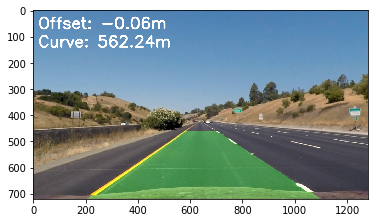

In [333]:

test_image = mpimg.imread('test_images/straight_lines1.jpg')

x1, x2, x3, x4, x5, ploty, left_fitx, right_fitx, drawed_field, offset, result = process_image(test_image)

plt.imshow(result)
   

## Pipeline

- Undistort
- Change perspective
- Gradient (Sobel)
- Color: convert to HLS and use S-channel
- Combine gradient and color
- Find lines
- Draw lane field

In [326]:
def process_image(img):
    undist_image = undistort(img)
    perspective_image = change_perspective(undist_image)
    
    # Gradient
    gradx_bin = gradient_sobel_threshold(perspective_image, 'x', 20, 100)
    grady_bin = gradient_sobel_threshold(perspective_image, 'x', 20, 100)
    mag_bin = mag_thresh(perspective_image, 3, (30, 100))
    dir_bin = dir_threshold(perspective_image, 3, (0.7, 1.3))
    sobel_bin = combine_thresholds(gradx_bin, grady_bin, mag_bin, dir_bin)
    
    # Color
    hls_binary = hls_select(perspective_image, thresh=(170, 255))
    
    # Color and gradient
    grad_color_bin = combine_binary(sobel_bin, hls_binary)
    
    ploty, left_fitx, right_fitx, left_fit, right_fit = find_lines(grad_color_bin)
    
    drawed_field, warp = draw_lane_field(undist_image, grad_color_bin, ploty, left_fitx, right_fitx)
    
    offset = calculate_offset_in_m(warp)
    
    lc, rc, mean_curve = calculate_curvature(ploty, left_fit, right_fit)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    result_offset = cv2.putText(drawed_field, str('Offset: {:.2f}m'.format(offset)) ,(20,70), font, 2, (255,255,255),5,cv2.LINE_AA)
    result_curve = cv2.putText(drawed_field, str('Curve: {:.2f}m'.format(mean_curve)) ,(20,140), font, 2, (255,255,255),5,cv2.LINE_AA)
    
    return undist_image, perspective_image, sobel_bin, hls_binary, grad_color_bin, ploty, left_fitx, right_fitx, drawed_field, offset, result_curve

## Pipeline on test images

6030.11817657 75352.2024888
613.237687708 m 516.143410395 m
22678.1636322 274647.669613
613.237687708 m 516.143410395 m
2301.66363626 2242.2609135
613.237687708 m 516.143410395 m
2860.3962096 1545.0670541
613.237687708 m 516.143410395 m
6106.66607268 3170.2211098
613.237687708 m 516.143410395 m
5746.28141493 2469.27101534
613.237687708 m 516.143410395 m
2089.16741712 1843.5318901
613.237687708 m 516.143410395 m
3454.49956742 1746.19221767
613.237687708 m 516.143410395 m


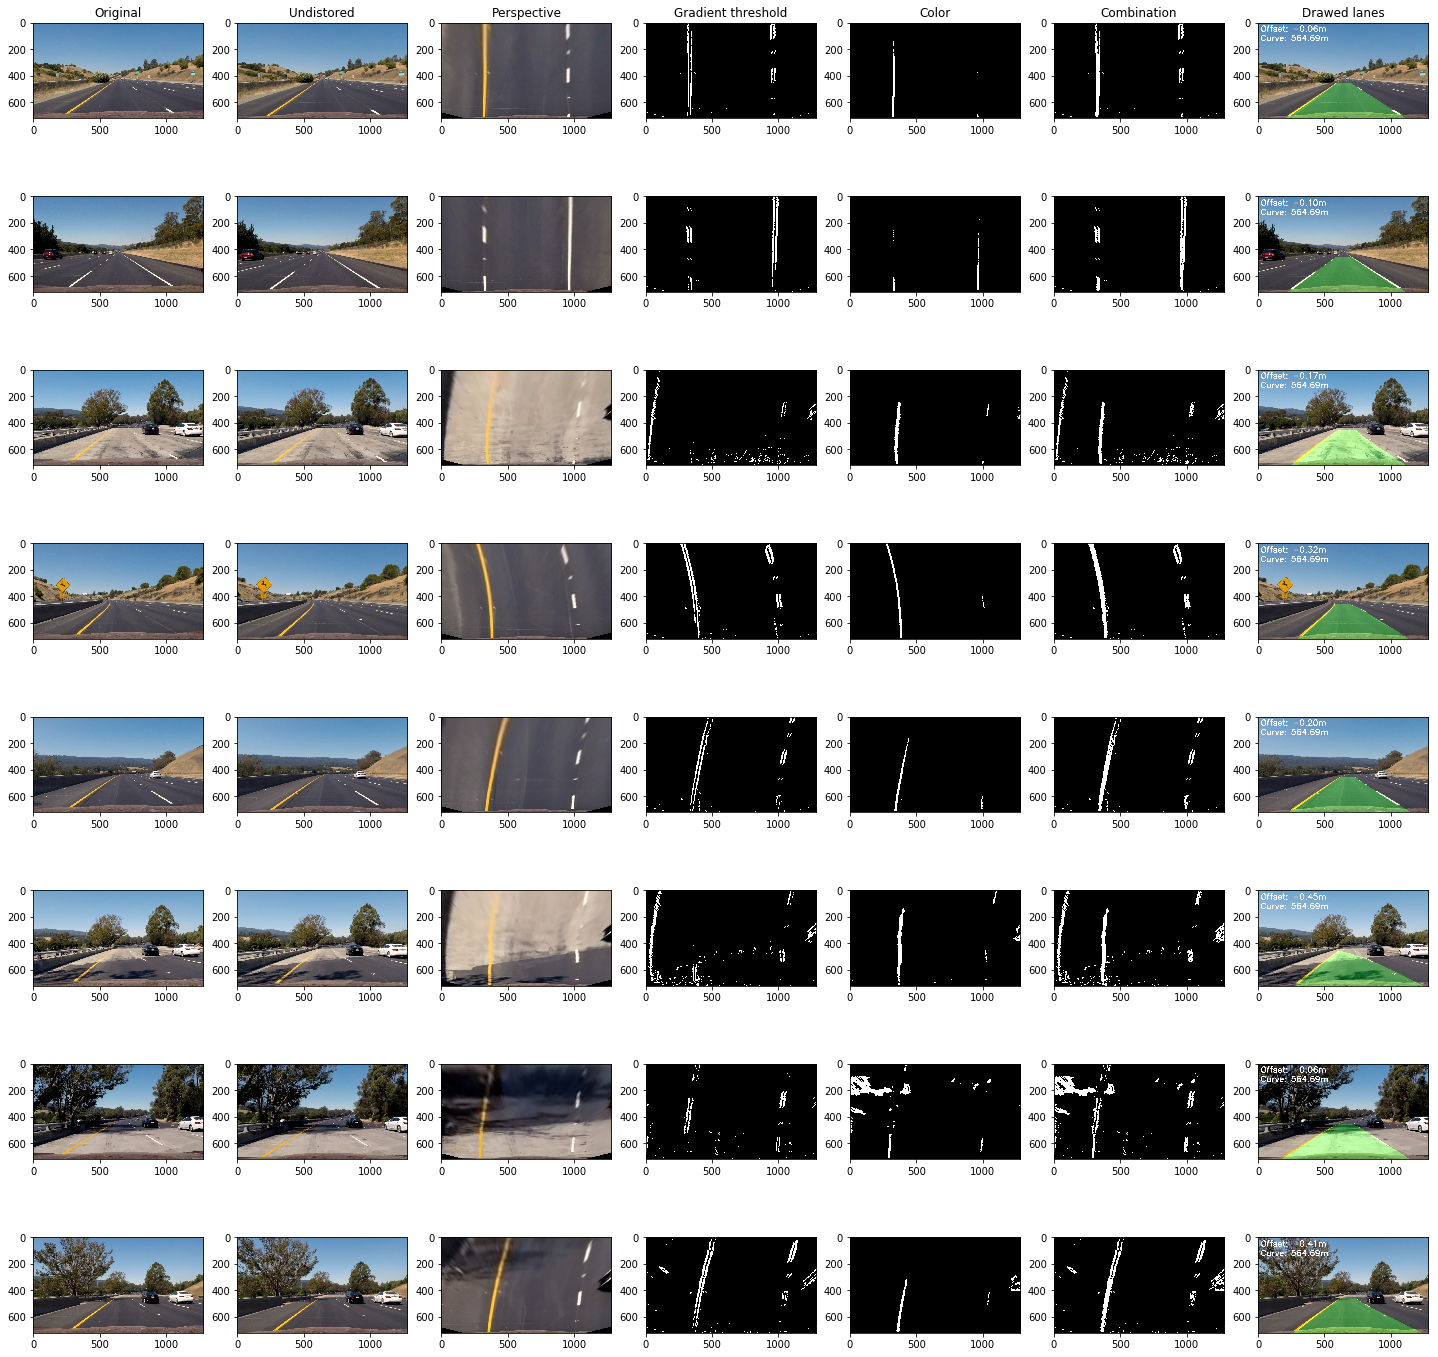

In [327]:
test_images = glob.glob('test_images/*.jpg')

f, axarr = plt.subplots(len(test_images), 7, figsize=(25,25))

for i, test_fname in enumerate(test_images):
    test_image = mpimg.imread(test_fname)
    
    undist_image, perspective_image, sobel_bin, hls_binary, grad_color_bin, ploty, left_fitx, right_fitx, drawed_field, offset, result = process_image(test_image)
    
    if i == 0:
        axarr[i,0].set_title('Original')
        axarr[i,1].set_title('Undistored')
        axarr[i,2].set_title('Perspective')
        axarr[i,3].set_title('Gradient threshold')
        axarr[i,4].set_title('Color')
        axarr[i,5].set_title('Combination')
        axarr[i,6].set_title('Drawed lanes')
    
    axarr[i,0].imshow(test_image)
    axarr[i,1].imshow(undist_image)
    axarr[i,2].imshow(perspective_image)
    axarr[i,3].imshow(sobel_bin, cmap='gray')
    axarr[i,4].imshow(hls_binary, cmap='gray')
    axarr[i,5].imshow(grad_color_bin, cmap='gray')
    axarr[i,6].imshow(result)
    
    mpimg.imsave('output_images/'+test_fname.split('/')[1], result)

# Pipeline on video

In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [214]:
def process_frame(image):
    undist_image, perspective_image, sobel_bin, hls_binary, grad_color_bin, ploty, left_fitx, right_fitx, drawed_field, offset, result = process_image(image)

    return result

In [215]:
output = 'output_images/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(process_frame)
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:15<00:00,  4.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 14min 57s, sys: 9.05 s, total: 15min 6s
Wall time: 4min 16s
